In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import pyfolio as pf

from openbb import obb
obb.user.preferences.output_type = "dataframe"

In [2]:
# This is the number of days we'll look back to 
# calculate the rolling z-score.
window = 22

# This is the number of standard deviations the 
# z-score needs to be above or below to trigger
# a trading signal.
thresh = 1.5

# Set the start date to today and the end date to
# two calendar years ago.
today = pd.Timestamp.today().strftime("%Y-%m-%d")
start_date = (pd.Timestamp.today() - pd.Timedelta(days=365*2)).strftime("%Y-%m-%d")

In [3]:
# Create a simple helper function to grab futures data.
def fetch_futures_from_openbb(ticker, start_date, end_date, expiry=None):
    data = obb.derivatives.futures.historical(ticker, start_date, end_date)
    data.rename(columns={"close": ticker}, inplace=True)
    data.index = pd.to_datetime(data.index)
    data.index = data.index.normalize()
    return data[ticker]

In [4]:
# OpenBB provides access to individual futures data which is fine
# for our strategy. This is heating oil, gasoline, and crude oil
# futures data.
ho = fetch_futures_from_openbb("HO", start_date, today)
rb = fetch_futures_from_openbb("RB", start_date, today)
cl = fetch_futures_from_openbb("CL", start_date, today)

In [5]:
# Get the refiner stock data for the same time range.
psx = obb.equity.price.historical(
    "PSX", 
    start_date=start_date, 
    end_date=today,
    provider="yfinance"
).close
psx.name = "PSX"

In [6]:
# Now put all the prices together.
data = pd.concat([ho, rb, cl, psx], axis=1).dropna()

In [7]:
# Construct the crack spread which we define as
# long 3 crude oil contracts and short 2 contracts
# of gasoline and short 1 contract of heating oil.
data["crack_spread"] = 3 * data.CL - 2 * data.RB - data.HO

<Axes: xlabel='date'>

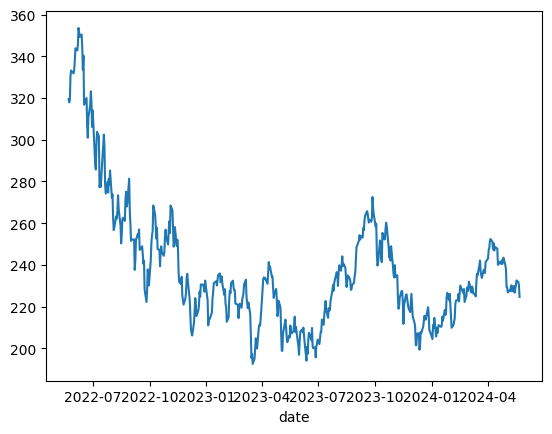

In [8]:
# Plot it.
data.crack_spread.plot()

In [9]:
# Create a pandas Series with the spread between the crack
# spread and the refiner price.
data["spread"] = data.crack_spread - data.PSX

<Axes: xlabel='date'>

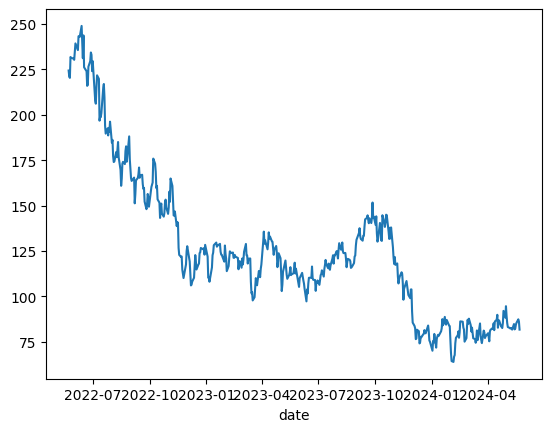

In [10]:
# Plot it.
data.spread.plot()

In [11]:
# Compute the daily return of the spread.
data["returns"] = data.spread.apply(np.log).diff(1)

In [12]:
# Compute the rolling z-score of the spread between
# the crack spread and the refiner price.
data["z"] = (
  data.spread
  - data.spread.rolling(window=window).mean()
) / data.spread.rolling(window=window).std()

In [13]:
# Create a position indicator to get short the spread
# if it increases above our threshold and long the
# spread if it decreases below our threshold.
data["position"] = np.select(
  [data.z < -thresh, data.z > thresh],
  [1, -1],
  default=0
)

In [14]:
# Then use it to determine the return of the strategy.
strategy_returns = data.position.shift(1) * data.returns

Start date,2022-05-23
End date,2024-05-22
Total months,23
,Backtest
Annual return,56.33%
Cumulative returns,143.957%
Annual volatility,28.351%
Sharpe ratio,1.72
Calmar ratio,2.37
Stability,0.92
Max drawdown,-23.817%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.82,2023-10-30,2023-12-06,2024-01-23,62
1,13.38,2022-11-17,2022-11-25,2023-04-13,106
2,9.37,2023-05-02,2023-05-03,2023-06-01,23
3,7.26,2024-02-01,2024-02-05,2024-03-13,30
4,6.85,2023-06-09,2023-06-12,2023-06-15,5


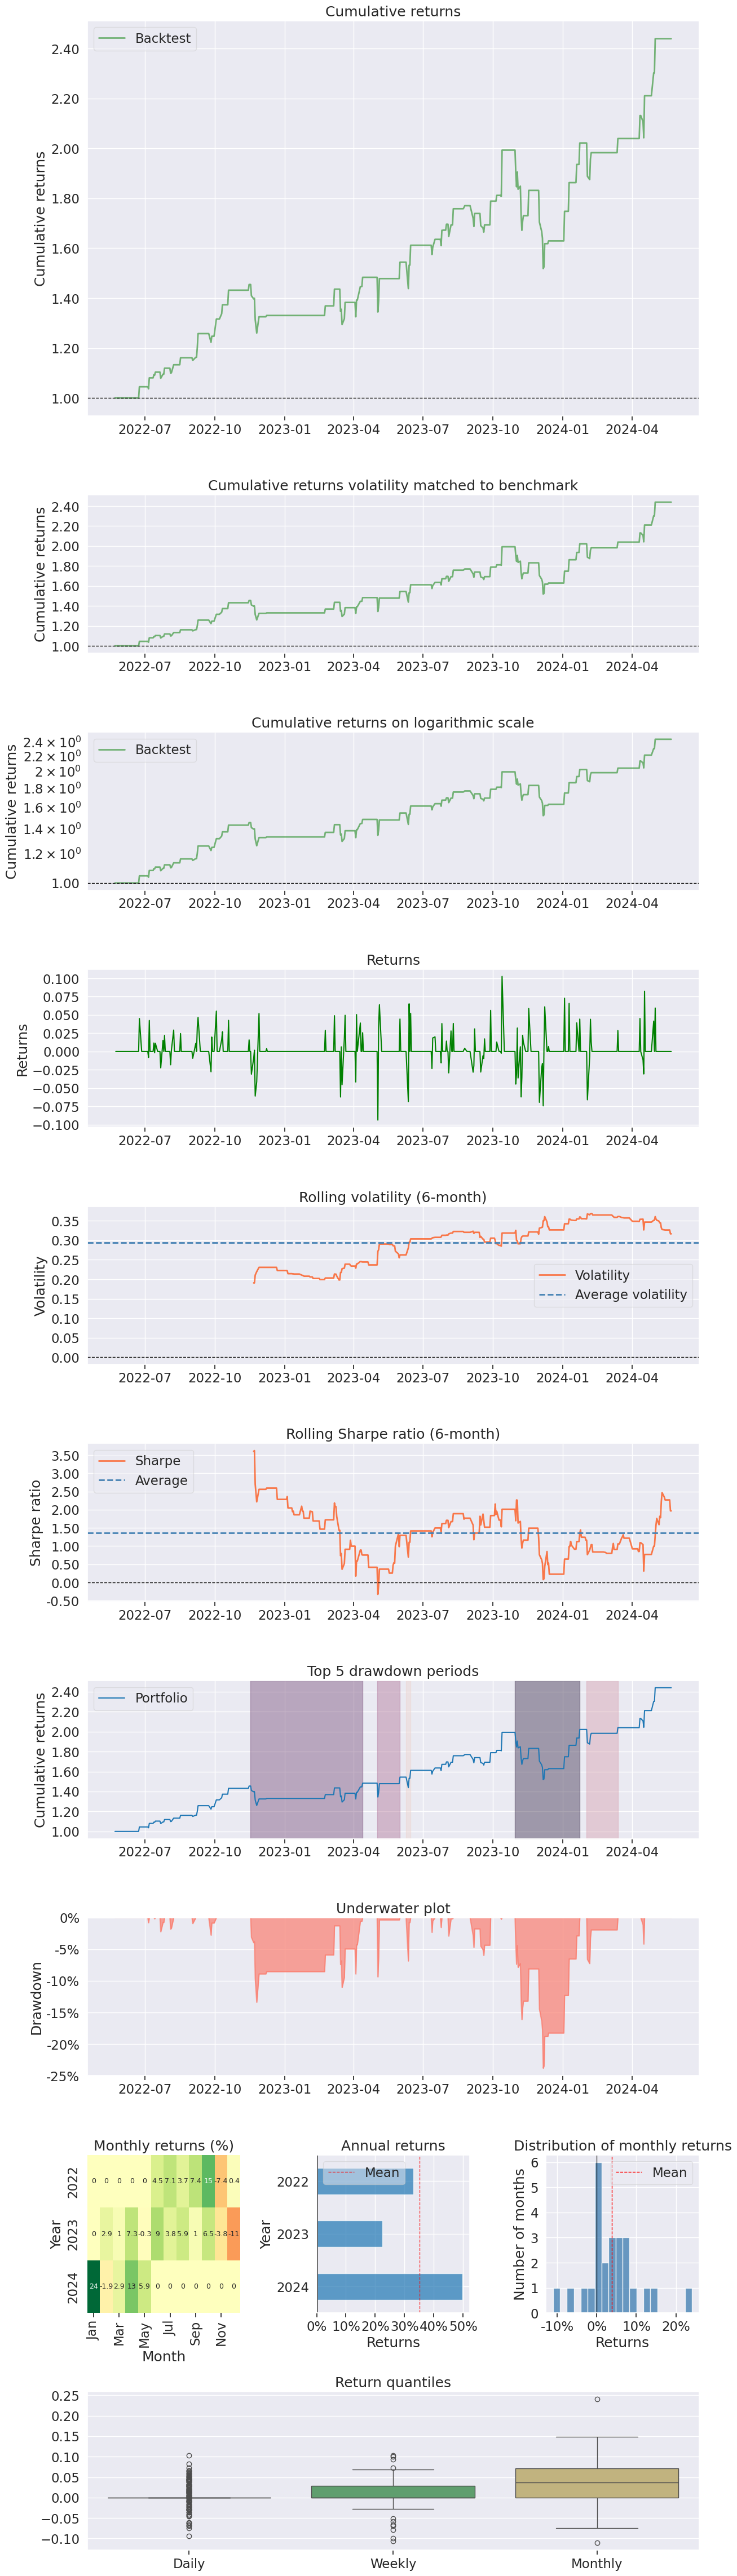

In [15]:
# Get a summary report of the statistics using Pyfolio
strategy_returns.index = pd.to_datetime(strategy_returns.index)
pf.create_full_tear_sheet(strategy_returns)